In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dakam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dakam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Perform the data exploration step (i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, plot example classes of the image, size of images, are sizes uniform? Do they need to be cropped? normalized? etc.
Plot your data. For tabular data, you will need to run scatters, for image data, you will need to plot your example classes.
How will you preprocess your data? You should explain this in your readme.md file and link your jupyter notebook to it. Your jupyter notebook should be uploaded to your repo.
Jupyter Notebook data download and environment setup requirements: 


In [5]:
df = pd.read_csv('Glassdoor_Job_Postings.csv')
df.head(5)

,company,job_title,company_rating,job_description,location,salary_avg_estimate,salary_estimate_payperiod,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.0,Junior Data Analyst\nTake your next career ste...,Bengaluru,"₹3,25,236",/yr (est.),10000+ Employees,1883,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.7,3.6,4.0,3.5,3.9
1,Philips,Data Scientist - AI/ML,4.0,Job Title\nData Scientist - AI/ML\nJob Descrip...,Bengaluru,NaN,NaN,10000+ Employees,1891,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.8,3.7,4.0,3.5,4.0
2,HSBC,Data Science GSC’s,3.9,Job description\nGraduate/ Post-graduate degre...,Bengaluru,NaN,NaN,10000+ Employees,1865,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.6,3.6,3.8,3.4,3.7
3,Facctum Solutions,Data Analyst,NaN,Job Description\nExperience: 0 - 2 years in da...,Karnataka,NaN,NaN,1 to 50 Employees,--,Company - Private,--,--,Unknown / Non-Applicable,NaN,NaN,NaN,NaN,NaN
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.0,JOB DESCRIPTION\n\nYou are a strategic thinker...,India,NaN,NaN,10000+ Employees,1799,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.0,3.9,3.9,3.6,3.7


## Data Preprocessing

In [6]:
# Convert company_founded to int
df['company_founded'] = df['company_founded'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)

In [7]:
# Convert salary_avg_estimate to float
df['salary_avg_estimate'] = df['salary_avg_estimate'].apply(lambda x: float(str(x).replace('₹', '').replace(',', '')) if pd.notna(x) else np.nan)

In [8]:
# Convert job_description to list
df['job_description'] = df['job_description'].apply(lambda x: x.split('\n') if pd.notna(x) else x)

### Data Imputation


In [9]:
## company column: inpute "unknown"

df['company'] = df['company'].fillna('Unknown')



## imputting ratings for company related ratings
df['career_opportunities_rating'] = df['career_opportunities_rating'].fillna(df['career_opportunities_rating'].mean())
df['comp_and_benefits_rating'] = df['comp_and_benefits_rating'].fillna(df['comp_and_benefits_rating'].mean())
df['culture_and_values_rating'] = df['culture_and_values_rating'].fillna(df['culture_and_values_rating'].mean())
df['senior_management_rating'] = df['senior_management_rating'].fillna(df['senior_management_rating'].mean())
df['work_life_balance_rating'] = df['work_life_balance_rating'].fillna(df['work_life_balance_rating'].mean())


## company rating: 
columns_to_average = ['career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating']

average_values = df[columns_to_average].mean(axis = 1)


df['company_rating'] = df['company_rating'].fillna(average_values)

## dropping job description nan

df.dropna(subset = ['job_description'],inplace = True)

## imputting salary_avg_estimate

# Perform KNN imputation
columns_to_drop = ['company', 'job_title', 'job_description', 'location', 'salary_estimate_payperiod',
                   'company_size', 'company_founded', 'employment_type', 'industry', 'sector', 'revenue']

data_for_imputation = df.drop(columns=columns_to_drop)

data_for_imputation = pd.get_dummies(data_for_imputation)

imputer = KNNImputer()

imputed_data = imputer.fit_transform(data_for_imputation)

df['salary_avg_estimate'] = imputed_data[:, data_for_imputation.columns.get_loc('salary_avg_estimate')]

## getting most frequent pay period and imputing missing values

df['salary_estimate_payperiod'] = df['salary_estimate_payperiod'].fillna(df['salary_estimate_payperiod'].mode()[0])



## company size imputtation 
df['company_size'] = df['company_size'].fillna('Unknown')


## company founded imputtation 

df['company_founded'] = df['company_founded'].fillna(0000.0)

## imputing employment_type, industry,sector,revenue

df['employment_type'] = df['employment_type'].fillna('Unknown')
df['industry'] = df['industry'].fillna('Unknown')
df['industry'] = df['industry'].replace('--','Unknown')

df['revenue'] = df['revenue'].fillna('Unknown')

df['sector'] = df['sector'].fillna('Unknown')
df['sector'] = df['sector'].replace('--','Unknown')

In [10]:
# Create salary_avg_per_year

# Convert salary_estimate_payperiod to factors 

factors = {'/yr (est.)': 1,
          '/mo (est.)': 12,
          '/hr (est.)': 2123}

df['salary_estimate_payperiod'] = df['salary_estimate_payperiod'].apply(lambda x: factors[x] if (type(x) == str) else x)

# Multiply 'salary_avg_estimate' by 'salary_estimate_payperiod'
df['salary_avg_estimate'] = df['salary_avg_estimate'] * df['salary_estimate_payperiod']

# Rename the column to 'salary_avg_estimate_per_year'
df = df.rename(columns={'salary_avg_estimate': 'salary_avg_estimate_per_year'})
df.drop(columns = 'salary_estimate_payperiod')

,company,job_title,company_rating,job_description,location,salary_avg_estimate_per_year,company_size,company_founded,employment_type,industry,sector,revenue,career_opportunities_rating,comp_and_benefits_rating,culture_and_values_rating,senior_management_rating,work_life_balance_rating
0,ABB,Junior Data Analyst,4.000000,"[Junior Data Analyst, Take your next career st...",Bengaluru,325236.0,10000+ Employees,1883.0,Company - Public,Electronics Manufacturing,Manufacturing,$10+ billion (USD),3.700000,3.600000,4.00000,3.500000,3.900000
1,Philips,Data Scientist - AI/ML,4.000000,"[Job Title, Data Scientist - AI/ML, Job Descri...",Bengaluru,657767.6,10000+ Employees,1891.0,Company - Public,Healthcare Services & Hospitals,Healthcare,$10+ billion (USD),3.800000,3.700000,4.00000,3.500000,4.000000
2,HSBC,Data Science GSC’s,3.900000,"[Job description, Graduate/ Post-graduate degr...",Bengaluru,615428.4,10000+ Employees,1865.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),3.600000,3.600000,3.80000,3.400000,3.700000
3,Facctum Solutions,Data Analyst,3.780438,"[Job Description, Experience: 0 - 2 years in d...",Karnataka,534300.0,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,3.838304,3.678796,3.90301,3.677702,3.804378
4,JPMorgan Chase & Co,Data and Analytics - Associate,4.000000,"[JOB DESCRIPTION, , You are a strategic thinke...",India,574184.4,10000+ Employees,1799.0,Company - Public,Banking & Lending,Finance,$10+ billion (USD),4.000000,3.900000,3.90000,3.600000,3.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,Kpro Solutions,Analytics & Data Science,4.000000,"[Experience & Qualification:, , Minimum of 9 y...",Bengaluru,483915.0,1 to 50 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.000000,4.000000,4.00000,4.000000,4.000000
896,Athena Global Technologies,Data Engineer,3.900000,"[Immediate requirement for Data Engineer, Expe...",Hyderābād,678949.0,51 to 200 Employees,0.0,Company - Private,Unknown,Unknown,Unknown / Non-Applicable,4.200000,3.500000,4.00000,3.900000,3.900000
897,Wesco,India-Bangalore: Data Engineer,3.700000,[This person will work independently or with a...,Bengaluru,651920.0,10000+ Employees,1922.0,Company - Public,Wholesale,Retail & Wholesale,$10+ billion (USD),3.500000,3.400000,3.60000,3.300000,3.800000
898,Course5,Data Scientist,4.200000,[If you meet our position requirements and can...,Bengaluru,424426.0,1001 to 5000 Employees,2000.0,Company - Private,Business Consulting,Management & Consulting,$100 to $500 million (USD),4.300000,4.100000,4.30000,4.100000,4.200000


In [11]:
# Add salary_ranges


bins = np.arange(min(df['salary_avg_estimate_per_year']),max(df['salary_avg_estimate_per_year']), 500000)

labels = range(len(bins) - 1)

# Add a new column 'salary_range' to the DataFrame based on the bins
df['salary_range'] = pd.cut(df['salary_avg_estimate_per_year'], bins=bins, labels=labels, include_lowest=True)
df
df = df.dropna(subset='salary_range')


### One hot encoding (removed)

In [12]:
# #one hot encode company size
# one_hot_encoder = OneHotEncoder(sparse=False)

# # Fit and transform the data
# encoded_data = one_hot_encoder.fit_transform(df[['company_size']])

# # Create a DataFrame from the encoded data
# encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['company_size']))

# # Concatenate with the original DataFrame
# df = pd.concat([df, encoded_df], axis=1)

# #one hot encode revenue

# # Fit and transform the data
# encoded_data = one_hot_encoder.fit_transform(df[['revenue']])

# # Create a DataFrame from the encoded data
# encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['revenue']))

# # Concatenate with the original DataFrame
# df = pd.concat([df, encoded_df], axis=1)

# #one hot encode sector
# one_hot_encoder = OneHotEncoder(sparse=False)

# encoded_data = one_hot_encoder.fit_transform(df[['sector']])

# encoded_df = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(['sector']))

# df = pd.concat([df, encoded_df], axis=1)

# df.head(5)

In [13]:
# # Concatenate text
# def tokenize(job_description):
#     def is_iterable(obj):
#         try:
#             iter(obj)
#             return True
#         except TypeError:
#             return False
#         if not is_iterable(job_description):
#             return None

# # Check if job_description is not iterable or is empty
#     if not is_iterable(job_description) or len(job_description) == 0:
#         return None

#     text = ''.join(job_description)

#     # Lowercase conversion
#     text = text.lower()
#     # Tokenization
#     tokens = word_tokenize(text)

#     # Removing punctuation and special characters
#     tokens = [re.sub(r'[^a-zA-Z0-9\s]', '', token) for token in tokens if token.isalnum()]

#     # Removing stopwords
#     stop_words = set(stopwords.words('english'))
#     tokens = [token for token in tokens if token not in stop_words]
#     # Feature extraction (optional)
#     # This can involve extracting skills, qualifications, responsibilities, etc. based on patterns in the text.
#     return tokens

# df['job_description'] = df['job_description'].apply(tokenize)
# df.dropna(subset=['job_description'], inplace=True)
# df['job_description'] = df['job_description'].apply(lambda x: ' '.join(x))

# # Initialize TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer()

# # Fit and transform the 'job_description' column
# tfidf_matrix = tfidf_vectorizer.fit_transform(df['job_description'])

# # Get feature names (words)
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Create a DataFrame for visualization (optional)
# df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# df = pd.concat([df, df_tfidf], axis=1)

# # Print the concatenated DataFrame
# numeric_columns = [col for col in df.columns if re.match(r'^\d', col)]
# df = df.drop(columns=numeric_columns)

## Data Exploration

## Plots

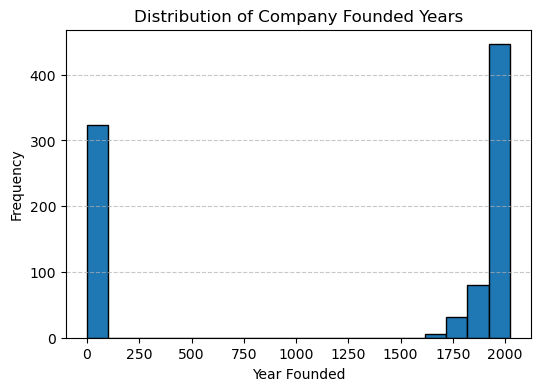

In [14]:
plt.figure(figsize=(6, 4))
plt.hist(df['company_founded'], bins=20, edgecolor='black')
plt.xlabel('Year Founded')
plt.ylabel('Frequency')
plt.title('Distribution of Company Founded Years')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [15]:
df['avg_rating'] = (df['career_opportunities_rating']+df['comp_and_benefits_rating']+ df['culture_and_values_rating']+df['senior_management_rating']+ df['work_life_balance_rating'])/5
df['avg_rating']

0      3.740000
1      3.800000
2      3.620000
3      3.780438
4      3.820000
         ...   
895    4.000000
896    3.900000
897    3.520000
898    4.200000
899    4.540000
Name: avg_rating, Length: 887, dtype: float64

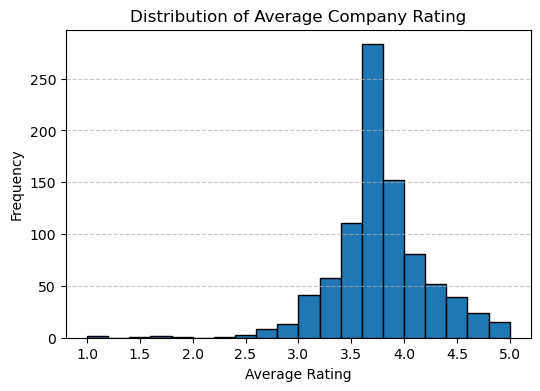

In [16]:
plt.figure(figsize=(6, 4))
plt.hist(df['avg_rating'], bins=20, edgecolor='black')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Average Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

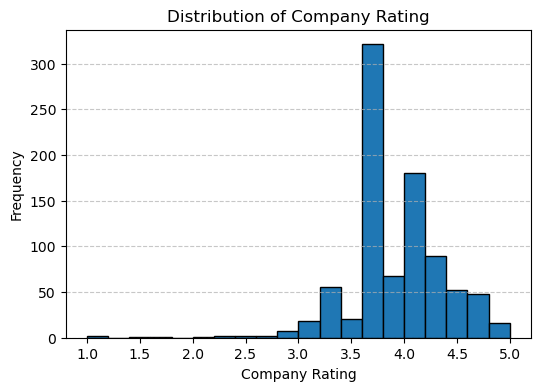

In [17]:
plt.figure(figsize=(6, 4))
plt.hist(df['company_rating'], bins=20, edgecolor='black')
plt.xlabel('Company Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Company Rating')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

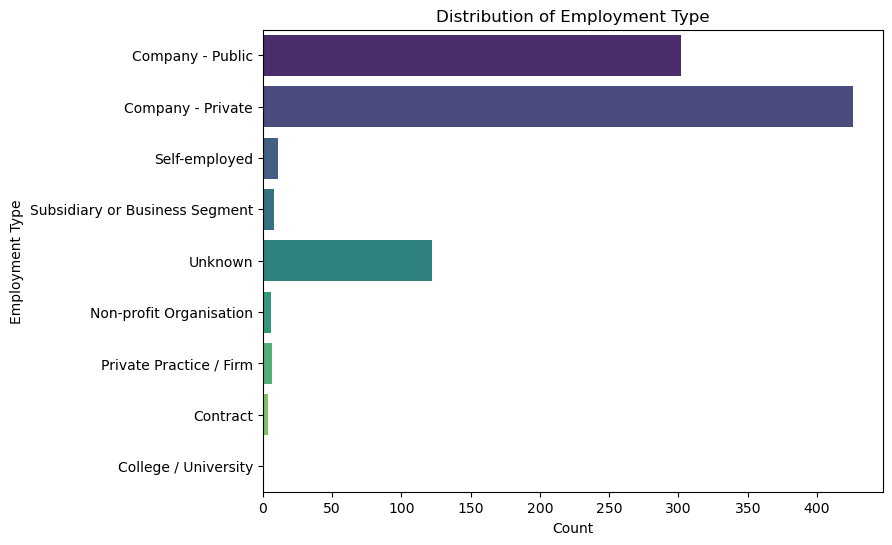

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(y='employment_type', data=df, palette='viridis')
plt.title('Distribution of Employment Type')
plt.xlabel('Count')
plt.ylabel('Employment Type')
plt.show()

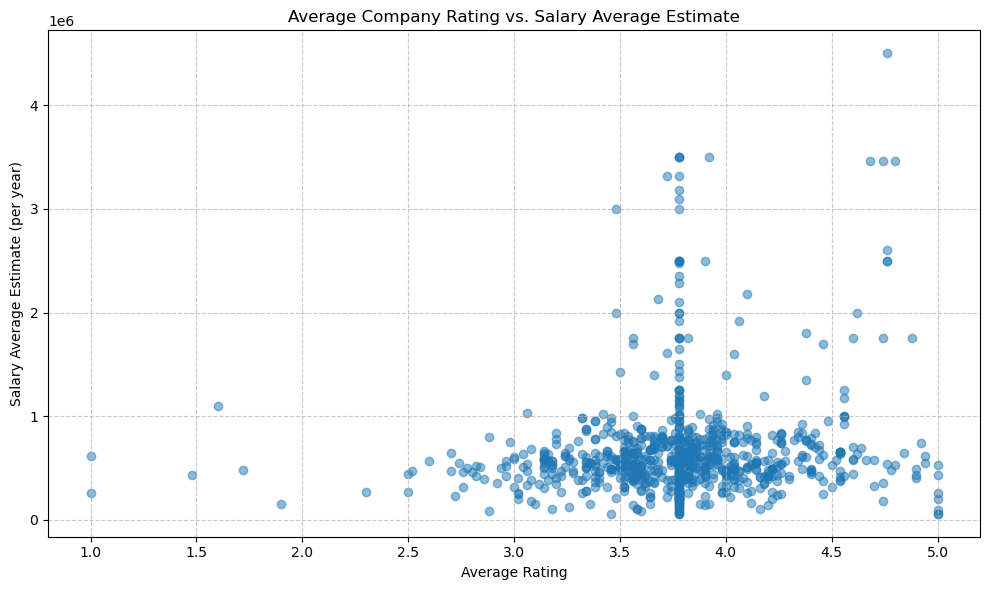

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df['avg_rating'], df['salary_avg_estimate_per_year'], alpha=0.5)
plt.xlabel('Average Rating')
plt.ylabel('Salary Average Estimate (per year)')
plt.title('Average Company Rating vs. Salary Average Estimate')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
# sector_columns = [col for col in df.columns if col.startswith('sector_')]
# data = df[['salary_avg_estimate_per_year'] + sector_columns]

# melted_data = data.melt(id_vars='salary_avg_estimate_per_year', var_name='Sector', value_name='Sector_Encoded')
# melted_data = melted_data[melted_data['Sector_Encoded'] == 1]

# plt.figure(figsize=(12, 8))
# sns.boxplot(x='salary_avg_estimate_per_year', y='Sector', data=melted_data, palette='viridis')
# plt.xlabel('Salary Average Estimate (per year)')
# plt.ylabel('Sector')
# plt.title('Salary Distribution Across Different Sectors')
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

### Confusion matrix for correlation

C:\Users\dakam\AppData\Local\Temp\ipykernel_14232\3531766010.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['salary_range'] = pd.to_numeric(selected_data['salary_range'], errors='coerce')


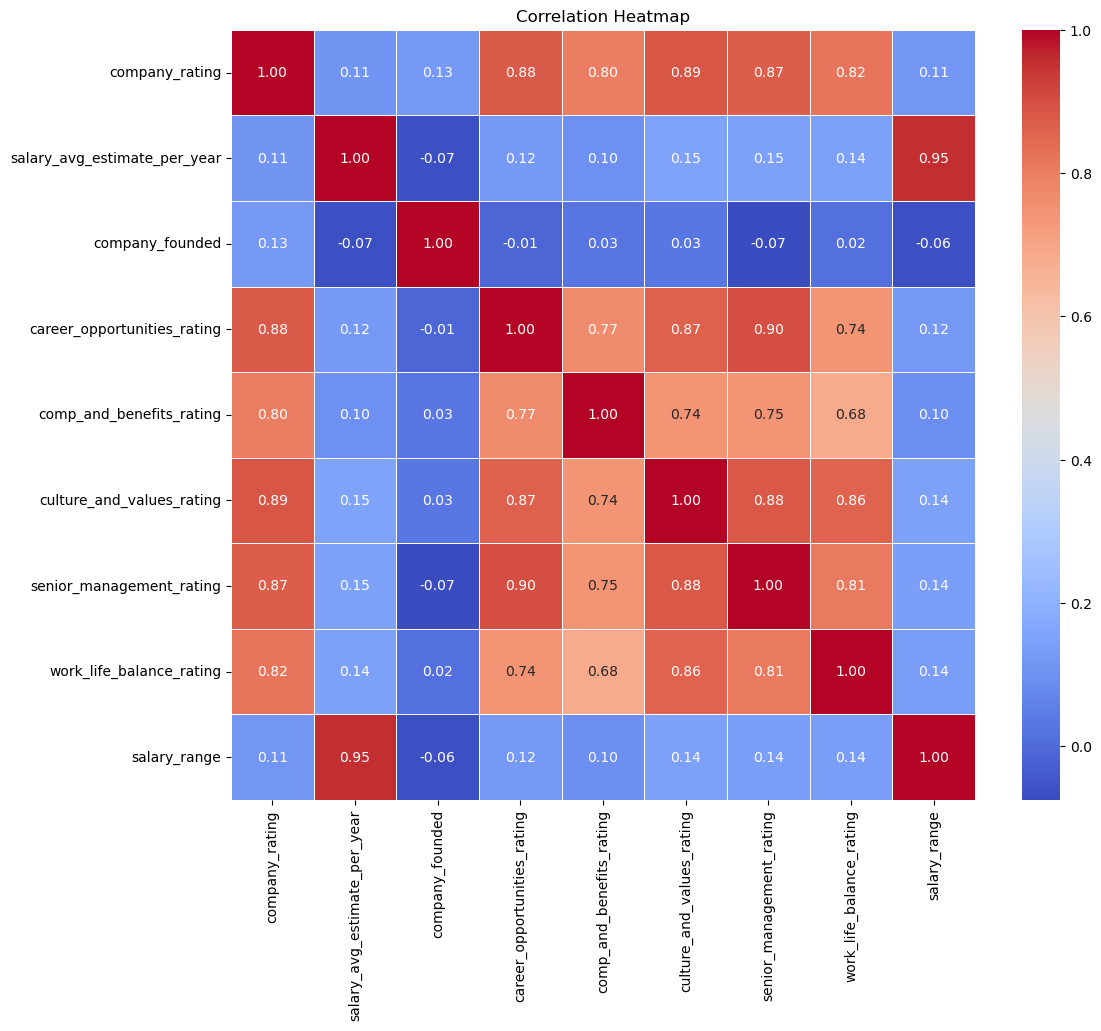

In [21]:
# Assuming your DataFrame is named 'df'
selected_columns = ['company_rating','salary_avg_estimate_per_year',
                    'company_size', 'company_founded','career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating', 'salary_range']

# Select the specified columns from the DataFrame
selected_data = df[selected_columns]


# Convert 'salary_range' to numeric (if not already)
selected_data['salary_range'] = pd.to_numeric(selected_data['salary_range'], errors='coerce')

# Drop rows with NaN values
selected_data = selected_data.dropna(subset=['salary_range'])

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


### Model 1: Linear Regression

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score



X = df[['company_rating', 'company_founded','career_opportunities_rating',
'comp_and_benefits_rating',       
'culture_and_values_rating',      
'senior_management_rating',       
'work_life_balance_rating']]


y = df['salary_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# # scaling to standardize values 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Initialize and train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = clf.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# # Display classification report
# print("Classification Report:")
# print(classification_report(y_test, predictions))



Accuracy: 0.68
Mean Squared Error: 1.1123595505617978


### Confusion matrix 

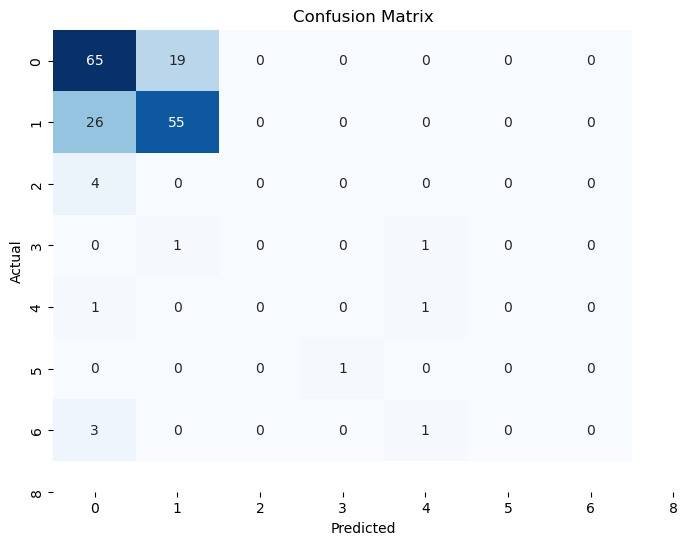

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Fitting plot 

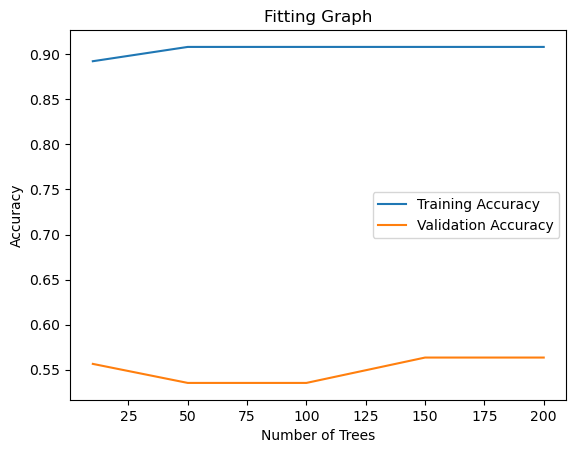

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define a range of values for the parameter you want to plot against
# For example, let's plot against the number of trees in the forest
param_values = [10, 50, 100, 150, 200]

# Initialize lists to store performance metrics
train_scores = []
val_scores = []

# Iterate over different values of the parameter
for param in param_values:
    # Initialize and train the model with the current parameter value
    clf = RandomForestClassifier(n_estimators=param, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    # Make predictions on training and validation sets
    train_predictions = clf.predict(X_train_scaled)
    val_predictions = clf.predict(X_val_scaled)
    
    # Compute performance metrics
    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    # Append the scores to the lists
    train_scores.append(train_accuracy)
    val_scores.append(val_accuracy)

# Plot the fitting graph
plt.plot(param_values, train_scores, label='Training Accuracy')
plt.plot(param_values, val_scores, label='Validation Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Fitting Graph')
plt.legend()
plt.show()
